### BERTweet Implementation

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
#torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

cpu
cpu


## PRE-PROCESSING

In [5]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob
import contractions
import re

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation, data splitting, and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report, 
                             precision_recall_fscore_support)

# Transformers and HuggingFace utilities
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, AutoConfig)

# Optimization tools
import optuna


In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [8]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [9]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [10]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [11]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [12]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [13]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [14]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [15]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [16]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [17]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [18]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


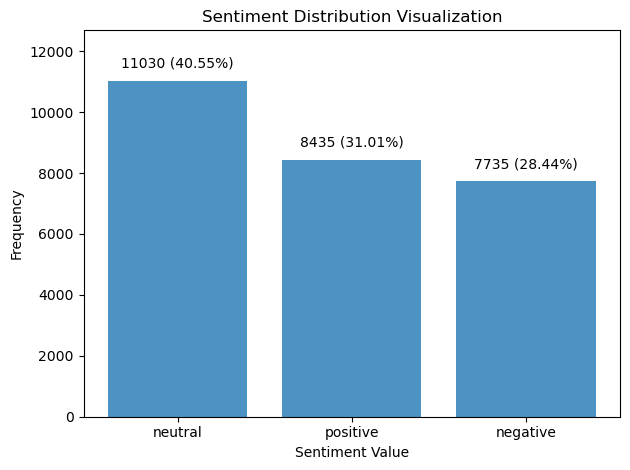

In [19]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [20]:
# --- Data Preparation ---

# Map the sentiments to numerical values
target_map = {'neutral':2,'positive':0,'negative':1}
df = df.copy()
df.loc[:, 'target'] = df['sentiment'].map(target_map)
df.head()

,sentiment,cleaned_tweets,target
0,neutral,i would have responded if i were going,2
1,negative,sooo sad i will miss you here in san diego,1
2,negative,my boss is bullying me,1
3,negative,what interview leave me alone,1
4,negative,sons of why could not they put them on the r...,1


In [34]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [22]:
# Split the data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['cleaned_tweets'], df['target'], test_size=0.3, random_state=5)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=5)

# Convert the label series to lists
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()
test_labels = test_labels.tolist()


In [23]:
# Load BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)


In [25]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization of a BERTweet sequence classification model.
    
    Parameters:
    - trial (optuna.trial.Trial): A trial object that suggests hyperparameter values for optimization.
    
    Returns:
    - best_validation_accuracy (float): The best accuracy obtained on the validation set during training.
    """
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    hidden_dropout_prob = trial.suggest_float("hidden_dropout_prob", 0.1, 0.5)
    
    # Configure the model with hyperparameters and predefined architecture
    config = AutoConfig.from_pretrained("vinai/bertweet-base", num_labels=3, hidden_dropout_prob=hidden_dropout_prob)
    model = AutoModelForSequenceClassification.from_config(config)
    model.to('cpu')
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir="model_dir",
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=32,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        evaluation_strategy="steps",
        save_steps=2000,
        metric_for_best_model='accuracy',
        logging_dir='./logs',
        greater_is_better=True,
        load_best_model_at_end=True,
    )
    
    # Initialize the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    best_validation_accuracy = trainer.evaluate()["eval_accuracy"]

    return best_validation_accuracy

#Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial's score and hyperparameters
print(f'Best trial: score {study.best_trial.value}, params {study.best_trial.params}')


[I 2023-08-27 08:44:58,656] A new study created in memory with name: no-name-b88c9166-a738-4608-9aea-bf0cb51eac13
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.107000,1.060747,0.411520
1000,1.078600,1.022240,0.465931


[I 2023-08-27 08:56:38,056] Trial 0 finished with value: 0.48676470588235293 and parameters: {'learning_rate': 4.2685479870621735e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.025514431455395215, 'hidden_dropout_prob': 0.2677637968911644}. Best is trial 0 with value: 0.48676470588235293.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.123600,1.086257,0.411520
1000,1.114000,1.115927,0.307353
1500,1.108900,1.086869,0.411520
2000,1.107500,1.085181,0.411520
2500,1.103100,1.086632,0.411520


[I 2023-08-27 09:25:14,224] Trial 1 finished with value: 0.41151960784313724 and parameters: {'learning_rate': 5.490865266488238e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.02445977332515985, 'hidden_dropout_prob': 0.35238118944019825}. Best is trial 0 with value: 0.48676470588235293.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.078300,1.003651,0.486520
1000,0.990500,0.954853,0.515196


[I 2023-08-27 09:36:41,469] Trial 2 finished with value: 0.5470588235294118 and parameters: {'learning_rate': 5.148355491743566e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.022537684712995467, 'hidden_dropout_prob': 0.1889836372458741}. Best is trial 2 with value: 0.5470588235294118.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.112900,1.075870,0.411520
1000,1.106500,1.048477,0.429412
1500,1.040600,0.974476,0.506618
2000,0.989500,0.913667,0.551961
2500,0.946500,0.912280,0.565196
3000,0.938600,0.893218,0.577451
3500,0.921300,0.897905,0.575980


[I 2023-08-27 09:59:38,621] Trial 3 finished with value: 0.5519607843137255 and parameters: {'learning_rate': 7.045704466960934e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.07534475655835057, 'hidden_dropout_prob': 0.33897880545276554}. Best is trial 3 with value: 0.5519607843137255.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.126800,1.073715,0.411520
1000,0.992100,0.905580,0.578922
1500,0.864200,0.862845,0.618137
2000,0.820000,0.817486,0.660539


[I 2023-08-27 10:22:13,689] Trial 4 finished with value: 0.6605392156862745 and parameters: {'learning_rate': 2.5735686741688906e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.029152785611750432, 'hidden_dropout_prob': 0.4294205774969602}. Best is trial 4 with value: 0.6605392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.124900,1.063130,0.411520
1000,0.968200,0.858868,0.608578


[I 2023-08-27 10:33:39,793] Trial 5 finished with value: 0.6115196078431373 and parameters: {'learning_rate': 3.471903018586616e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.02880778334772445, 'hidden_dropout_prob': 0.3728739712774348}. Best is trial 4 with value: 0.6605392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.095200,1.074592,0.419363
1000,1.009300,0.945520,0.540931
1500,0.946800,0.875688,0.590441
2000,0.898600,0.866408,0.574755
2500,0.861000,0.862718,0.591667
3000,0.841100,0.830579,0.622059
3500,0.832700,0.804765,0.631618
4000,0.804600,0.837640,0.627206
4500,0.798600,0.804724,0.637255
5000,0.759700,0.798322,0.642892


[I 2023-08-27 11:11:33,234] Trial 6 finished with value: 0.6272058823529412 and parameters: {'learning_rate': 5.269649677555653e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.06273157359656985, 'hidden_dropout_prob': 0.16072446223538905}. Best is trial 4 with value: 0.6605392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.121400,1.076199,0.411520
1000,1.112300,1.052012,0.423039
1500,1.061600,1.026009,0.480882
2000,1.008900,0.939504,0.536520


[I 2023-08-27 11:26:48,301] Trial 7 finished with value: 0.5365196078431372 and parameters: {'learning_rate': 8.013450432975328e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.06637270567489365, 'hidden_dropout_prob': 0.359627421131697}. Best is trial 4 with value: 0.6605392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.055400,0.944227,0.521078
1000,0.929900,0.885826,0.573039
1500,0.868900,0.841610,0.611275
2000,0.846100,0.826742,0.618382


[I 2023-08-27 11:49:23,144] Trial 8 finished with value: 0.6183823529411765 and parameters: {'learning_rate': 5.950736549234946e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.026875548573611574, 'hidden_dropout_prob': 0.16160563837731026}. Best is trial 4 with value: 0.6605392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.094100,1.034874,0.474755
1000,0.941700,0.861404,0.594363
1500,0.874900,0.865712,0.608824
2000,0.810200,0.837885,0.637745
2500,0.775300,0.837193,0.636029
3000,0.719000,0.778501,0.667647
3500,0.726300,0.754920,0.667647
4000,0.671600,0.791425,0.675000
4500,0.666900,0.753302,0.684559


[I 2023-08-27 12:19:50,539] Trial 9 finished with value: 0.675 and parameters: {'learning_rate': 1.4258824949416529e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.0007582354370409884, 'hidden_dropout_prob': 0.1891466987626471}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.089200,1.062438,0.425735
1000,1.076000,1.052836,0.418627


[I 2023-08-27 12:27:36,912] Trial 10 finished with value: 0.43970588235294117 and parameters: {'learning_rate': 1.4299722304914938e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 16, 'weight_decay': 0.0024010422832600633, 'hidden_dropout_prob': 0.11025968682471946}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.141800,1.088462,0.411520
1000,1.135800,1.092189,0.411520
1500,1.131000,1.100269,0.411520
2000,1.120600,1.095031,0.411520
2500,1.112000,1.096226,0.411520
3000,1.063300,0.928953,0.546569
3500,0.966000,0.914127,0.564951
4000,0.920300,0.903340,0.591912
4500,0.893600,0.913624,0.592402


[I 2023-08-27 12:58:03,536] Trial 11 finished with value: 0.5919117647058824 and parameters: {'learning_rate': 2.3563954502152676e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.0003081631891954928, 'hidden_dropout_prob': 0.478306254732122}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.141700,1.084632,0.411520
1000,1.138400,1.092813,0.411520
1500,1.132700,1.095660,0.411520
2000,1.129400,1.095289,0.411520
2500,1.117200,1.068901,0.417892
3000,1.051700,1.050243,0.499510
3500,0.984600,0.948833,0.530392
4000,0.949100,0.938315,0.570098
4500,0.927100,0.921950,0.572059


[I 2023-08-27 13:28:30,362] Trial 12 finished with value: 0.5700980392156862 and parameters: {'learning_rate': 1.7893181411094835e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.0448763500066977, 'hidden_dropout_prob': 0.49421385891824593}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.123100,1.085158,0.411520
1000,1.109300,1.118222,0.307353
1500,1.102200,1.089839,0.411520


[I 2023-08-27 13:45:29,199] Trial 13 finished with value: 0.41151960784313724 and parameters: {'learning_rate': 8.62181741395325e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.08724479727311571, 'hidden_dropout_prob': 0.2564706385747031}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.129100,1.082589,0.411520
1000,1.069300,0.936115,0.525980
1500,0.936000,0.915179,0.564706
2000,0.898300,0.860734,0.611520


[I 2023-08-27 14:08:11,456] Trial 14 finished with value: 0.6115196078431373 and parameters: {'learning_rate': 1.6764948155635213e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.011516480431068689, 'hidden_dropout_prob': 0.41701122347067493}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.115300,1.088517,0.431127
1000,1.026100,0.923527,0.554657
1500,0.935000,0.873464,0.602696
2000,0.874000,0.942552,0.579412
2500,0.829800,0.881045,0.618137
3000,0.797000,0.823866,0.642157
3500,0.789600,0.771209,0.662745
4000,0.746800,0.805524,0.664216
4500,0.741500,0.796366,0.667892
5000,0.712200,0.794304,0.671569


[I 2023-08-27 14:46:48,547] Trial 15 finished with value: 0.6642156862745098 and parameters: {'learning_rate': 1.2704176048757585e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.04490666352150642, 'hidden_dropout_prob': 0.2947346498510579}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.108300,1.050396,0.451716
1000,1.001600,0.884780,0.563480
1500,0.912100,0.853656,0.607108
2000,0.864700,0.886580,0.595098
2500,0.829100,0.834616,0.622059
3000,0.794600,0.789563,0.649265
3500,0.774200,0.781519,0.655392
4000,0.753200,0.794691,0.657598
4500,0.734500,0.779498,0.668137
5000,0.703900,0.787666,0.667402


[I 2023-08-27 15:24:47,829] Trial 16 finished with value: 0.6575980392156863 and parameters: {'learning_rate': 1.0675523747690886e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.04498637219539812, 'hidden_dropout_prob': 0.2432812448311072}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.121600,1.084995,0.439216
1000,1.043000,0.902203,0.556373
1500,0.924100,0.878670,0.597059
2000,0.872400,0.856028,0.612745
2500,0.834500,0.823669,0.629902
3000,0.803200,0.795205,0.652941
3500,0.773900,0.787754,0.658088
4000,0.750800,0.807199,0.661520
4500,0.739500,0.788660,0.670098
5000,0.705000,0.804374,0.672304


[I 2023-08-27 16:02:39,523] Trial 17 finished with value: 0.6615196078431372 and parameters: {'learning_rate': 1.2769435518734933e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.09794719594424144, 'hidden_dropout_prob': 0.2952347956192623}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.120900,1.105022,0.307353
1000,1.112800,1.087096,0.411520
1500,1.105400,1.084818,0.411520
2000,1.105500,1.094313,0.307353
2500,1.096800,1.089456,0.411520
3000,1.100600,1.084745,0.411520
3500,1.092800,1.065834,0.421324


[I 2023-08-27 16:25:38,686] Trial 18 finished with value: 0.3073529411764706 and parameters: {'learning_rate': 4.307502594262731e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.04090068586136282, 'hidden_dropout_prob': 0.21800574960826408}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.110800,1.101685,0.396814
1000,1.030900,0.898379,0.560049
1500,0.943400,0.867267,0.587990
2000,0.877500,0.859270,0.600000
2500,0.840200,0.832431,0.628186
3000,0.812100,0.801202,0.652451
3500,0.783200,0.789096,0.658578
4000,0.762400,0.799770,0.655637
4500,0.757700,0.784449,0.665196
5000,0.725400,0.794973,0.666176


[I 2023-08-27 17:03:31,672] Trial 19 finished with value: 0.6556372549019608 and parameters: {'learning_rate': 1.1852894446340523e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05605546855427107, 'hidden_dropout_prob': 0.3026901614002704}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.103400,1.063273,0.414216
1000,1.085100,1.027755,0.452941
1500,1.037400,1.012561,0.478922
2000,0.993600,0.946369,0.522304
2500,0.958000,0.926814,0.542892
3000,0.944000,0.911718,0.562255
3500,0.940800,0.897376,0.571324
4000,0.920100,0.907976,0.565441
4500,0.912300,0.886241,0.572304


[I 2023-08-27 17:33:58,921] Trial 20 finished with value: 0.5654411764705882 and parameters: {'learning_rate': 2.786878855629246e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.037608033539455715, 'hidden_dropout_prob': 0.21375549890092532}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.116500,1.085523,0.411765
1000,1.046700,0.962714,0.532108
1500,0.935400,0.861179,0.597059
2000,0.875200,0.845035,0.620588
2500,0.824200,0.827699,0.638235
3000,0.787600,0.820941,0.643382
3500,0.777400,0.791281,0.661029
4000,0.739300,0.798110,0.672304
4500,0.724400,0.790697,0.672794
5000,0.702100,0.795673,0.671078


[I 2023-08-27 18:11:55,827] Trial 21 finished with value: 0.6723039215686275 and parameters: {'learning_rate': 1.3735918986088733e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.09583238389119685, 'hidden_dropout_prob': 0.29453089919014325}. Best is trial 9 with value: 0.675.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.122800,1.089867,0.425735
1000,1.032200,0.890825,0.567892
1500,0.900100,0.881156,0.593873
2000,0.841600,0.857728,0.626961
2500,0.802400,0.820464,0.655392
3000,0.763900,0.795308,0.668137
3500,0.738600,0.778073,0.668627
4000,0.706400,0.797371,0.678676
4500,0.700600,0.795360,0.684069
5000,0.663100,0.801307,0.683578


[I 2023-08-27 18:49:52,999] Trial 22 finished with value: 0.6786764705882353 and parameters: {'learning_rate': 1.6537240709672837e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05519068137831055, 'hidden_dropout_prob': 0.2954972146163285}. Best is trial 22 with value: 0.6786764705882353.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.114000,1.068572,0.408088
1000,0.965200,0.901153,0.565686
1500,0.859200,0.875222,0.624020
2000,0.800300,0.835434,0.640686
2500,0.767300,0.816690,0.670098
3000,0.719300,0.798024,0.678431
3500,0.701300,0.751871,0.687745
4000,0.656200,0.793437,0.687010
4500,0.648700,0.789123,0.694118
5000,0.611300,0.801318,0.694118


[I 2023-08-27 19:27:51,095] Trial 23 finished with value: 0.6870098039215686 and parameters: {'learning_rate': 2.0503481577550024e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05398598842396098, 'hidden_dropout_prob': 0.2701657792487996}. Best is trial 23 with value: 0.6870098039215686.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.104400,0.976137,0.512500
1000,0.933400,0.842045,0.608824
1500,0.839300,0.812956,0.646324
2000,0.774600,0.826816,0.650000
2500,0.742300,0.789214,0.676716
3000,0.693700,0.772895,0.680147
3500,0.679700,0.735733,0.691422
4000,0.633800,0.772855,0.691176
4500,0.624900,0.760586,0.696569


[I 2023-08-27 19:58:22,892] Trial 24 finished with value: 0.6911764705882353 and parameters: {'learning_rate': 2.1708927078749916e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05339731070034126, 'hidden_dropout_prob': 0.23357225673007237}. Best is trial 24 with value: 0.6911764705882353.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.113400,1.090996,0.455147
1000,0.994800,0.891784,0.583333
1500,0.857100,0.852095,0.623284
2000,0.792400,0.845504,0.661029
2500,0.745500,0.813428,0.670833
3000,0.694300,0.767788,0.679167
3500,0.675300,0.738092,0.689461
4000,0.623300,0.786489,0.695833
4500,0.617700,0.739954,0.702696
5000,0.589700,0.764951,0.699510


[I 2023-08-27 20:36:25,413] Trial 25 finished with value: 0.6958333333333333 and parameters: {'learning_rate': 2.3392805942469323e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05440328333079075, 'hidden_dropout_prob': 0.25063965427570883}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.101100,0.939388,0.549510
1000,0.929900,0.831989,0.613235
1500,0.830400,0.819403,0.650735
2000,0.765300,0.806299,0.660539
2500,0.728600,0.788858,0.683578
3000,0.679400,0.762247,0.683088
3500,0.664000,0.746226,0.687745


[I 2023-08-27 20:59:30,122] Trial 26 finished with value: 0.6605392156862745 and parameters: {'learning_rate': 2.5561383958316996e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.053183390887766045, 'hidden_dropout_prob': 0.23648739530159296}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.122300,1.094521,0.411520
1000,1.115200,1.081604,0.411520
1500,0.998300,0.889639,0.583333
2000,0.850800,0.861592,0.638480
2500,0.774400,0.804812,0.662990
3000,0.710500,0.774262,0.682353
3500,0.686700,0.751814,0.687255
4000,0.628800,0.743997,0.690441
4500,0.630700,0.745715,0.694608


[I 2023-08-27 21:30:04,115] Trial 27 finished with value: 0.6904411764705882 and parameters: {'learning_rate': 3.39303862927485e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.06247321203811164, 'hidden_dropout_prob': 0.2641258241576701}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.117200,1.094247,0.411520
1000,1.116200,1.092564,0.411520
1500,1.107500,1.085361,0.411520
2000,1.109900,1.098210,0.307353
2500,1.099700,1.089599,0.411520
3000,1.104600,1.088793,0.411520
3500,1.101300,1.085105,0.411520
4000,1.095400,1.092031,0.411520
4500,1.101200,1.088760,0.411520


[I 2023-08-27 22:00:39,227] Trial 28 finished with value: 0.41151960784313724 and parameters: {'learning_rate': 3.2606652502590356e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.06643260336808651, 'hidden_dropout_prob': 0.23550779530947227}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.130800,1.095241,0.411520
1000,1.121400,1.093589,0.411520
1500,1.114300,1.087865,0.411520
2000,1.115800,1.096083,0.307353
2500,1.103000,1.090024,0.411520
3000,1.108600,1.084969,0.411520
3500,1.103200,1.085495,0.411520


[I 2023-08-27 22:23:46,157] Trial 29 finished with value: 0.3073529411764706 and parameters: {'learning_rate': 5.8494429031818955e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.07578928907085548, 'hidden_dropout_prob': 0.3202978927913171}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.120500,1.083431,0.411520
1000,1.066600,0.924167,0.525735


[I 2023-08-27 22:31:36,530] Trial 30 finished with value: 0.5553921568627451 and parameters: {'learning_rate': 3.356901419578884e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 16, 'weight_decay': 0.06144739533254949, 'hidden_dropout_prob': 0.26606319295395914}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.116300,1.118756,0.376716
1000,0.990900,0.862522,0.588725
1500,0.882400,0.825938,0.635539
2000,0.804300,0.832520,0.650735
2500,0.768000,0.786416,0.667157
3000,0.719700,0.788610,0.668137
3500,0.695400,0.737807,0.691176
4000,0.656900,0.792386,0.688725
4500,0.647000,0.769903,0.694853
5000,0.613800,0.764813,0.693382


[I 2023-08-27 23:09:37,976] Trial 31 finished with value: 0.6887254901960784 and parameters: {'learning_rate': 2.1055129751802792e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.050230869632403335, 'hidden_dropout_prob': 0.270165767574648}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.112000,0.998350,0.476471
1000,0.953900,0.846914,0.608333
1500,0.847400,0.870467,0.629167
2000,0.776800,0.830698,0.650000
2500,0.743500,0.794861,0.682108
3000,0.690200,0.768784,0.672059
3500,0.676200,0.748615,0.689706
4000,0.629000,0.787858,0.693627
4500,0.618900,0.765111,0.695588


[I 2023-08-27 23:40:15,999] Trial 32 finished with value: 0.6936274509803921 and parameters: {'learning_rate': 2.499047461230651e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.04982293409388147, 'hidden_dropout_prob': 0.266674398246229}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.124400,1.102312,0.411520
1000,1.118200,1.087094,0.411520
1500,1.113100,1.087583,0.411520
2000,1.113800,1.104719,0.281127
2500,1.105100,1.089219,0.411520
3000,1.104400,1.088668,0.411520
3500,1.102000,1.085440,0.411520
4000,1.100800,1.094869,0.411520
4500,1.103100,1.089235,0.411520


[I 2023-08-28 00:10:54,190] Trial 33 finished with value: 0.41151960784313724 and parameters: {'learning_rate': 5.1959163688559535e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.058835124627198976, 'hidden_dropout_prob': 0.26865099064543074}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.115000,1.079236,0.469608
1000,0.970000,0.856972,0.598284
1500,0.823500,0.805922,0.649265
2000,0.756800,0.808485,0.668627
2500,0.715400,0.774753,0.682108
3000,0.666500,0.742863,0.684559
3500,0.638300,0.742638,0.687745


[I 2023-08-28 00:34:03,392] Trial 34 finished with value: 0.6686274509803921 and parameters: {'learning_rate': 2.879664634437225e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.050107754353179323, 'hidden_dropout_prob': 0.21937432053682926}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.125800,1.089994,0.411520
1000,1.121500,1.088631,0.411520
1500,1.114500,1.087230,0.411520
2000,1.110700,1.105171,0.307353
2500,1.104800,1.090660,0.411520
3000,1.107000,1.088358,0.411520
3500,1.103000,1.085474,0.411520
4000,1.100100,1.094083,0.411520
4500,1.104700,1.090060,0.411520


[I 2023-08-28 01:04:42,741] Trial 35 finished with value: 0.41151960784313724 and parameters: {'learning_rate': 4.13244735101072e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.03583900650933111, 'hidden_dropout_prob': 0.31731643206348203}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.053400,0.885335,0.564216
1000,0.844100,0.836230,0.621569
1500,0.747600,0.790039,0.663480
2000,0.700300,0.777211,0.676225


[I 2023-08-28 01:27:23,405] Trial 36 finished with value: 0.6762254901960785 and parameters: {'learning_rate': 2.4927701080092692e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.07308784597306114, 'hidden_dropout_prob': 0.25583734112880224}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.115100,1.072094,0.411520
1000,1.079100,0.978081,0.519853
1500,0.994900,0.923837,0.545588
2000,0.943400,0.921809,0.569363
2500,0.901800,0.870911,0.595833
3000,0.883000,0.859023,0.603676
3500,0.883800,0.851001,0.609559


[I 2023-08-28 01:50:48,073] Trial 37 finished with value: 0.5693627450980392 and parameters: {'learning_rate': 9.599147733729168e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.04833448905130969, 'hidden_dropout_prob': 0.3358555281916723}. Best is trial 25 with value: 0.6958333333333333.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.111100,1.126760,0.392892
1000,0.950300,0.844383,0.615931
1500,0.815500,0.822646,0.629902
2000,0.749700,0.797175,0.668873
2500,0.708600,0.786303,0.686275
3000,0.638800,0.798365,0.669608
3500,0.636800,0.731554,0.691422
4000,0.578600,0.743610,0.698039
4500,0.574500,0.753357,0.696569


[I 2023-08-28 02:22:25,512] Trial 38 finished with value: 0.6980392156862745 and parameters: {'learning_rate': 2.8337878528723636e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05919640226444356, 'hidden_dropout_prob': 0.20334239998464515}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.027500,0.875171,0.573039
1000,0.858500,0.825754,0.625000


[I 2023-08-28 02:33:56,353] Trial 39 finished with value: 0.6284313725490196 and parameters: {'learning_rate': 1.715720188067891e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.036020376066192086, 'hidden_dropout_prob': 0.17943968163444063}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.098400,0.958885,0.504657
1000,0.926400,0.844514,0.609069
1500,0.843100,0.839987,0.621078
2000,0.777100,0.787007,0.671814
2500,0.728800,0.807409,0.679412
3000,0.679300,0.756232,0.695098
3500,0.675100,0.739633,0.694853
4000,0.626300,0.762541,0.697549
4500,0.618500,0.739146,0.703186


[I 2023-08-28 03:04:52,404] Trial 40 finished with value: 0.6975490196078431 and parameters: {'learning_rate': 2.045732501512822e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05765626739462766, 'hidden_dropout_prob': 0.2054775353596721}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.098100,0.955920,0.525490
1000,0.932000,0.870433,0.590686
1500,0.829300,0.795134,0.651961
2000,0.767800,0.836029,0.663235
2500,0.728900,0.765246,0.682108
3000,0.673400,0.757304,0.680147
3500,0.660000,0.728463,0.696078
4000,0.613000,0.762987,0.693873
4500,0.601400,0.738950,0.700980


[I 2023-08-28 03:35:50,142] Trial 41 finished with value: 0.6938725490196078 and parameters: {'learning_rate': 2.1223637558829393e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05723503403536146, 'hidden_dropout_prob': 0.20173158748114328}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.110900,1.140913,0.310049
1000,1.113500,1.085816,0.411520
1500,1.107800,1.085438,0.411520
2000,1.074400,1.034368,0.513235
2500,0.888900,0.881591,0.571814
3000,0.812400,0.807301,0.635049
3500,0.768800,0.759385,0.661765
4000,0.697400,0.788052,0.668873
4500,0.673400,0.753054,0.678186


[I 2023-08-28 04:06:54,405] Trial 42 finished with value: 0.6688725490196078 and parameters: {'learning_rate': 2.6767069056813815e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05910646440252606, 'hidden_dropout_prob': 0.20250095588811517}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.097600,0.971662,0.500735
1000,0.927700,0.852662,0.600735
1500,0.827600,0.795282,0.658578
2000,0.768500,0.826962,0.666422
2500,0.728400,0.768817,0.684314
3000,0.670800,0.764534,0.674020
3500,0.660200,0.729625,0.697549
4000,0.606600,0.776768,0.693382
4500,0.599400,0.740804,0.701225


[I 2023-08-28 04:38:05,116] Trial 43 finished with value: 0.6933823529411764 and parameters: {'learning_rate': 2.1444450586982785e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.06577865167093935, 'hidden_dropout_prob': 0.1980259340117487}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.086300,1.044467,0.453922
1000,0.972200,0.912362,0.556127
1500,0.904700,0.849774,0.604412
2000,0.859500,0.847264,0.608088
2500,0.816700,0.815938,0.631127
3000,0.790100,0.814096,0.636275
3500,0.777200,0.800569,0.639951


[I 2023-08-28 05:01:28,401] Trial 44 finished with value: 0.6080882352941176 and parameters: {'learning_rate': 9.51766687486612e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.06896832769081736, 'hidden_dropout_prob': 0.17266929351255877}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.105900,1.072201,0.456373
1000,0.987000,0.911091,0.546814
1500,0.866300,0.823139,0.634069
2000,0.782700,0.768799,0.671569
2500,0.718500,0.779346,0.685784
3000,0.650700,0.759081,0.680147
3500,0.646200,0.721991,0.697059
4000,0.573400,0.775425,0.691667
4500,0.572300,0.735674,0.700000
5000,0.528700,0.785332,0.692647


[I 2023-08-28 05:40:30,336] Trial 45 finished with value: 0.6916666666666667 and parameters: {'learning_rate': 3.0338285316432447e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.059583015618635424, 'hidden_dropout_prob': 0.14514206763753768}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.035500,0.870252,0.576716
1000,0.863600,0.870510,0.580882
1500,0.781100,0.791989,0.649755
2000,0.747300,0.774551,0.669118


[I 2023-08-28 06:03:39,942] Trial 46 finished with value: 0.6691176470588235 and parameters: {'learning_rate': 1.580762527843832e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.04846215594456003, 'hidden_dropout_prob': 0.2029324061406485}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.120500,1.098344,0.412255
1000,1.113800,1.087371,0.411520
1500,1.105100,1.085600,0.411520
2000,1.104900,1.097995,0.307353
2500,1.008400,0.966732,0.528922
3000,0.915600,0.902803,0.558333
3500,0.887800,0.874352,0.565441


[I 2023-08-28 06:27:49,765] Trial 47 finished with value: 0.3073529411764706 and parameters: {'learning_rate': 4.0695785480969936e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.057864185957756636, 'hidden_dropout_prob': 0.18146581772050693}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.074500,0.956158,0.535294
1000,0.911900,0.827628,0.625245
1500,0.822800,0.833347,0.632598
2000,0.754600,0.771261,0.675000
2500,0.712800,0.763030,0.676716
3000,0.657600,0.741773,0.684314
3500,0.649400,0.731554,0.683578
4000,0.596500,0.751970,0.693382
4500,0.595100,0.730478,0.697549


[I 2023-08-28 06:59:22,869] Trial 48 finished with value: 0.6933823529411764 and parameters: {'learning_rate': 1.940217962068367e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.06386101920748029, 'hidden_dropout_prob': 0.15085665547882618}. Best is trial 38 with value: 0.6980392156862745.
/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.104800,1.059057,0.429167
1000,0.971300,0.869616,0.586275
1500,0.877700,0.836596,0.618382
2000,0.817600,0.840564,0.641912
2500,0.777200,0.798259,0.662745
3000,0.730500,0.782464,0.669363
3500,0.718200,0.751267,0.679902
4000,0.678500,0.775752,0.685784
4500,0.664600,0.760081,0.693382
5000,0.642300,0.760560,0.688235


[I 2023-08-28 07:39:24,991] Trial 49 finished with value: 0.6857843137254902 and parameters: {'learning_rate': 1.4796801385849105e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.07129542840654016, 'hidden_dropout_prob': 0.22307006705353358}. Best is trial 38 with value: 0.6980392156862745.


Best trial: score 0.6980392156862745, params {'learning_rate': 2.8337878528723636e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05919640226444356, 'hidden_dropout_prob': 0.20334239998464515}


In [25]:
# Setting hyperparameters from best trial
best_params = {
    'learning_rate': 2.8337878528723636e-05,
    'num_train_epochs': 6,#Original found was 4. Changing it to get better results. 
    'per_device_train_batch_size': 16,
    'weight_decay': 0.05919640226444356,
    'hidden_dropout_prob': 0.20334239998464515
}

config = AutoConfig.from_pretrained("vinai/bertweet-base", num_labels=3, hidden_dropout_prob=best_params['hidden_dropout_prob'])
model = AutoModelForSequenceClassification.from_config(config)
model.to('cpu')

training_args = TrainingArguments(
    output_dir="model_dir",
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=32,
    num_train_epochs=best_params['num_train_epochs'],
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
    evaluation_strategy="steps",
    save_steps=2000,
    metric_for_best_model='accuracy',
    logging_dir='./logs',
    greater_is_better=True,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


/Users/anshulvij/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,1.114800,1.087570,0.411520
1000,0.992500,0.852350,0.602206
1500,0.825800,0.807290,0.653922
2000,0.751000,0.766816,0.670588
2500,0.702400,0.920519,0.680392
3000,0.637200,0.773282,0.697059
3500,0.638800,0.736009,0.704167
4000,0.560900,0.778918,0.703186
4500,0.560400,0.771262,0.705147
5000,0.525600,0.770829,0.703676


TrainOutput(global_step=7140, training_loss=0.6553010625331676, metrics={'train_runtime': 2787.6425, 'train_samples_per_second': 40.981, 'train_steps_per_second': 2.561, 'total_flos': 2230872890561280.0, 'train_loss': 0.6553010625331676, 'epoch': 6.0})

In [27]:
# Predict on validation data
predictions, labels, _ = trainer.predict(test_dataset)
predictions = predictions.argmax(-1)

print(classification_report(labels, predictions, digits=4))


              precision    recall  f1-score   support

           0     0.7376    0.7889    0.7624      1265
           1     0.7970    0.5854    0.6750      1194
           2     0.6395    0.7298    0.6816      1621

    accuracy                         0.7059      4080
   macro avg     0.7247    0.7014    0.7064      4080
weighted avg     0.7160    0.7059    0.7048      4080



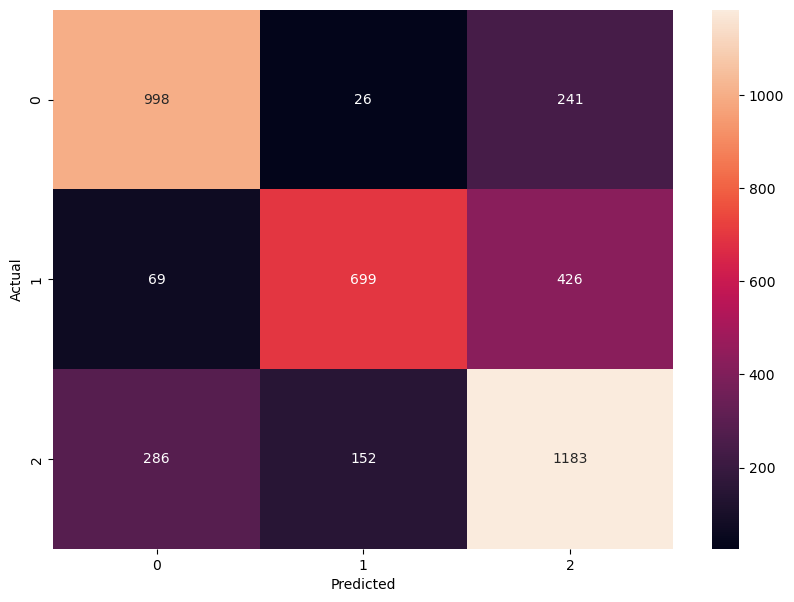

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [35]:
cm = np.array([[998, 26, 241], 
               [69, 699, 426], 
               [286, 152, 1183]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.8413
FPR: 0.1587
Precision: 0.7376

Metrics for class negative (Class value: 1):
Specificity: 0.9245
FPR: 0.0755
Precision: 0.797

Metrics for class neutral (Class value: 2):
Specificity: 0.7179
FPR: 0.2821
Precision: 0.6395

Overall accuracy: 0.7059
Weighted average specificity: 0.8166
Weighted average FPR: 0.1834
Macro average specificity: 0.8279
Macro average FPR: 0.1721



In [31]:
def display_misclassified_tweets(predictions, labels, test_texts, num_display=20):
    misclassified_idxs = (predictions != labels).nonzero()[0]
    misclassified_texts = test_texts.iloc[misclassified_idxs].tolist()
    misclassified_preds = predictions[misclassified_idxs]
    misclassified_labels = labels[misclassified_idxs]

    for idx in range(min(num_display, len(misclassified_texts))):
        print(f"Tweet: {misclassified_texts[idx]}")
        print(f"Predicted: {misclassified_preds[idx]}, Actual: {misclassified_labels[idx]}")
        print("---------------------")

display_misclassified_tweets(predictions, labels, test_texts)


Tweet: how i wish the result is true
Predicted: 0, Actual: 2
---------------------
Tweet: back at the vet and it is not good
Predicted: 0, Actual: 1
---------------------
Tweet:  dinner done shower done now time to chill with block of chocolate
Predicted: 2, Actual: 0
---------------------
Tweet:  it is a dreary monday morning and i slept like give me a break
Predicted: 2, Actual: 1
---------------------
Tweet:  two macaroons go into a barone says oh your a nut  wow i need to get out more
Predicted: 2, Actual: 0
---------------------
Tweet: _radio yeah s i feel all funny cause i have not slept enough  i woke my mum up cause i was singing she is not impressed s you
Predicted: 2, Actual: 1
---------------------
Tweet:  that would be soooooo much and geeky to the ultimate level but i work  to am
Predicted: 2, Actual: 0
---------------------
Tweet: on my way to school of my last friday of high school ever  and i do not even get to see holly gabbie and hannah
Predicted: 2, Actual: 1
-------